# show relation between DMS prediction and learning curve

## twister-P1

In [10]:
%cd /Users/sumishunsuke/Desktop/RNA/genzyme

import subprocess
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/Users/sumishunsuke/Desktop/RNA/genzyme


In [11]:
random_seeds = range(10)
for i, seed in enumerate(random_seeds):
    cmd = f"""
    python ./scripts/train_CMVAE.py \
    --data_dir ./datasets/ForDMSdata/RF03160 \
    --X_train RF03160_unique_addtemp_AGUCT_notrunc_traceback_onehot_cm_train.h5 \
    --w_train RF03160_unique_addtemp_AGUCT_notrunc_traceback_onehot_cm_train_weight_threshold0p2.h5 \
    --X_valid RF03160_unique_addtemp_AGUCT_notrunc_traceback_onehot_cm_valid.h5 \
    --w_valid RF03160_unique_addtemp_AGUCT_notrunc_traceback_onehot_cm_valid_weight_threshold0p2.h5 \
    --beta 0.016 \
    --log \
    --log_dir ./outputs/ForDMSdata/RF03160/timecource_cmvae  \
    --use_anneal \
    --use_early_stopping \
    --save_ckpt \
    --ckpt_iter 3 \
    --random_seed {str(seed)} \
    --suffix _trial{str(i).zfill(2)}
    """
    # res = subprocess.run(cmd, shell = True, capture_output = True)
    print(f"trial {str(i).zfill(2)}, done")
    print(res.stderr.decode())

trial 00, done


NameError: name 'res' is not defined

In [ ]:
# pred dms

ckpts = !ls -t ./outputs/ForDMSdata/RF03160/timecourse_cmvae/*.pt
ckpts_dict = {f"trial{str(i).zfill(2)}":{} for i in range(10)}
for ckpt in ckpts:
    ckpt_name = ckpt.split("/")[-1].split("_")[-1].replace(".pt", "")
    epoch = int(ckpt.split("/")[-1].split("_")[-2].replace("epoch", ""))
    ckpts_dict[ckpt_name][epoch] = ckpt

ckpts_dict["trial00"]

{43: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch43_trial00.pt',
 42: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch42_trial00.pt',
 39: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch39_trial00.pt',
 36: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch36_trial00.pt',
 33: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch33_trial00.pt',
 30: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch30_trial00.pt',
 27: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch27_trial00.pt',
 24: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch24_trial00.pt',
 21: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch21_trial00.pt',
 18: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch18_trial00.pt',
 15: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch15_trial00.pt',
 12: './outputs/ForDMSdata/RF03160/timecourse_cmvae/model_epoch12_trial00.pt',
 9: './outputs/ForDMSdata/RF03160/timecourse_cmvae/m

In [ ]:
!ls ./datasets/ForDMSdata/RF03160/activity/*h5

./datasets/ForDMSdata/RF03160/activity/Kobori2016_notrunc_traceback_onehot_cm.h5
./datasets/ForDMSdata/RF03160/activity/Kobori2016_notrunc_traceback_onehot_cm_test.h5
./datasets/ForDMSdata/RF03160/activity/Kobori2016_notrunc_traceback_onehot_cm_train.h5
./datasets/ForDMSdata/RF03160/activity/Kobori2016_notrunc_traceback_onehot_cm_valid.h5


In [ ]:
dms_trsp = "./datasets/ForDMSdata/RF03160/activity/Li2016_notrunc_traceback_onehot_cm.h5"


cmd = f"""
ls -t ./outputs/ForDMSdata/RF03160/timecourse_cmvae/*.pt | \
xargs -P7 -I @ python ./scripts/pred_activity_with_CMVAE.py \
--in_trsp {dms_trsp} \
--ckpt @ \
--model_config ./outputs/ForDMSdata/RF03160/timecourse_cmvae/config_trial00.yaml \
--n_samples 5 \
"""


res = subprocess.run(cmd, shell = True, capture_output = True)
print(res.stderr.decode())

# comparison between loss and dms pred

In [13]:
!pwd

/Users/sumishunsuke/Desktop/RNA/genzyme


In [14]:
def load_dms_results(file):
    eve = []
    with open(file, "r") as f: 
        for line in f:
            if not line.startswith("#"):
                eve.append(float(line))

    return eve


def get_dict_pred():
    d = {}
    for i in range(10):
        d_trial = {}
        pred_files_trial = !ls -t ./outputs/ForDMSdata/RF03160/timecourse_cmvae/*trial{str(i).zfill(2)}*.txt
        for pred_file in pred_files_trial:
            epoch = int(pred_file.split("/")[-1].split("_")[1].replace("epoch", ""))
            
            d_trial[epoch] = load_dms_results(pred_file)
        d[i] = d_trial
    return d


d = get_dict_pred()

In [19]:
# load activity
import pandas as pd
from Bio import SeqIO

info_mut = []
fasta = open("./datasets/ForDMSdata/RF03160/activity/Kobori2016.fa", "r")
for record in SeqIO.parse(fasta, "fasta"):
    mut = record.description.split(" ")[-1].split("/")
    if len(mut) == 1:
        mut = [mut[0], mut[0]]
    info_mut.append(mut)
info_mut[:3]



df_act = pd.read_excel("./datasets/ForDMSdata/RF03160/activity/Kobori_ACIE_2016_Supporting_Data.xlsx", skiprows=2, index_col = 0)
fitness = []
for mut in info_mut: 
    fitness.append(df_act[mut[0]][mut[1]])

fitness[:4]

[0.06536164879798889,
 0.07337608188390732,
 0.0888296589255333,
 0.022178495302796364]

In [20]:
# load loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

d_spearmanr = {}
for i in range(10):
    d_spearmanr[i] = {}
    for epoch in d[i].keys():
        corr, p = spearmanr(fitness, d[i][epoch])
        d_spearmanr[i][epoch] = corr

d_spearmanr[1][3]

0.13746302995927764

In [22]:
# load all loss

d_trial = {}
for i in range(10):

    df_loss = pd.read_csv(f"./outputs/ForDMSdata/RF03160/timecourse_cmvae/log_valid_trial{str(i).zfill(2)}.csv")
    df_loss.head()
    df_loss["Spearman's ρ"]= [np.nan for i in df_loss.index]
    for idx in df_loss.index:
        try:
            df_loss["Spearman's ρ"][idx] = d_spearmanr[i][idx]
        except:
            pass

    d_trial[i] = df_loss

d_trial[1].head()

,loss_valid,kl_valid,elbo_valid,Spearman's ρ
0,121.060133,4.376657,121.620346,NaN
1,115.994011,4.608173,116.583858,NaN
2,113.880493,3.209692,114.291334,NaN
3,116.938877,2.385079,117.244165,0.137463
4,114.153534,2.479915,114.470962,NaN


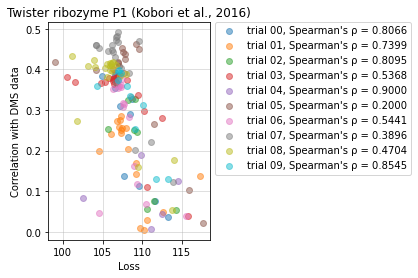

In [30]:
for i in range(10):
    df_tmp = d_trial[i].dropna(axis = 0)
    corr, p = spearmanr(df_tmp["elbo_valid"], df_tmp["Spearman's ρ"])

    plt.scatter(
        df_tmp["elbo_valid"],
        df_tmp["Spearman's ρ"].abs(), alpha = 0.5, label = f"trial {str(i).zfill(2)}, Spearman's ρ = {corr:.4f}")
plt.grid(alpha = 0.5)
plt.legend(loc = (1.03, 0.3))
plt.xlabel("Loss")
plt.ylabel("Correlation with DMS data")
plt.title("Twister ribozyme P1 (Kobori et al., 2016)")
plt.subplots_adjust(right = 0.5)
# plt.savefig("./outputs/figures/suppfig_dmspred_and_loss_twister.pdf", transparent = True)